In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from h5py import File
import pandas as pd
import xarray as xr
from glob import glob
import scipy.optimize as opt
import seaborn as sns
import os

TCCON_FOLDER = os.path.join(os.environ['HOME'], 'shared/ssim-ghg-data/tccon/tccon.latest.public')

#TCCON_FOLDER = os.path.join(os.environ['HOME'],'Google Drive/My Drive/csu_summer_school/tccon.latest.public')

# Analysis of LEF TCCON data
## Read in LEF data at all levels and create afternoon averages for each day


In [2]:
files = glob(TCCON_FOLDER+'/pa*')
lef_all = {}
lef_day = {}
for fi in files:
    st = fi.split('/')[-1][:2]
    tmp = xr.open_dataset(fi)
    #t = np.array([dt.datetime(1970,1,1) + dt.timedelta(days=ti/86400.) for ti in tmp['time'][:].data])
    lef_all[st] = pd.DataFrame({'xco2':tmp['xco2'].data,'lat':tmp['lat'].data,'lon':tmp['long'].data},index=pd.DatetimeIndex(tmp['time'].data))
    solar_time = np.array([lef_all[st].index[i] + dt.timedelta(hours=lef_all[st]['lon'].iloc[i]/180. * 12) for i in range(len(lef_all[st].index))])
    lef_all[st].index = solar_time[:]

for st in lef_all.keys():
    lef_day[st] = lef_all[st].between_time('12:00','16:00').groupby(pd.Grouper(freq='D')).mean()
    lef_day[st] = lef_day[st].dropna()

## Plot full and afternoon averaged time series to see impacts of filtering

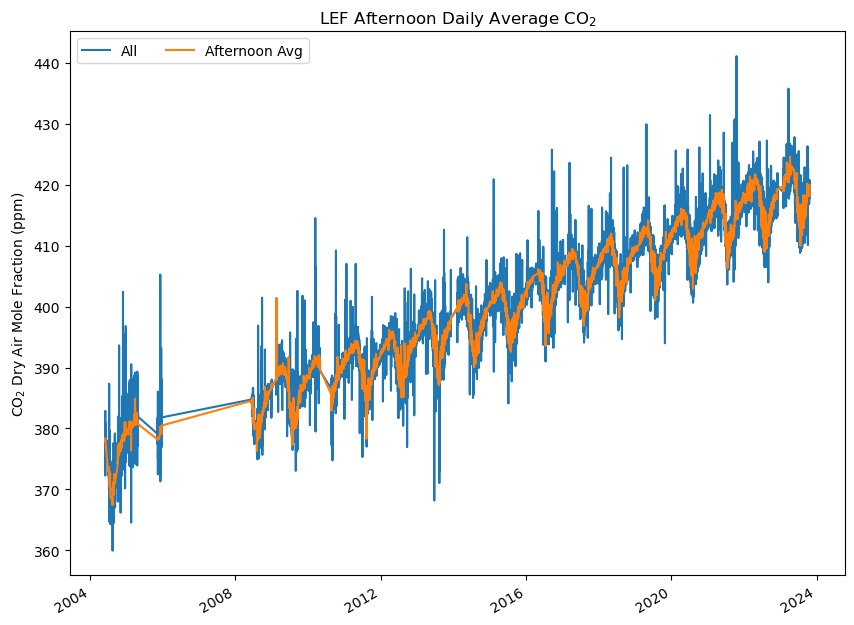

In [3]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
sites = [st]
for ky in sites:
  lef_all[ky].xco2.plot(title='LEF Full CO$_2$ Record',ax=ax)
  lef_day[ky].xco2.plot(title='LEF Afternoon Daily Average CO$_2$',ax=ax)
ax.legend(['All','Afternoon Avg'],ncol=3)
ax.set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');


#### Zoom in on a few recent years

As long as you have a DateTime index for your DataFrame, you can subsample with the DateTime objects directly

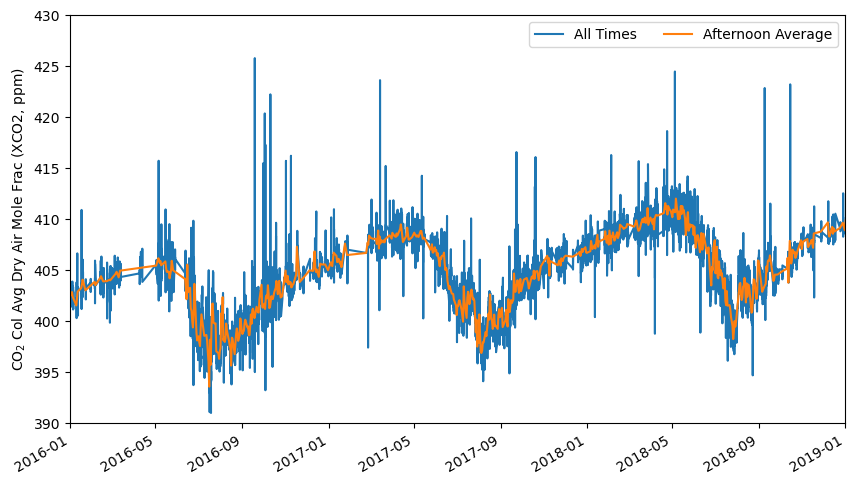

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sites=['pa']
for ky in sites:
  lef_all[ky].xco2.plot(ax=ax)
  lef_day[ky].xco2.plot(ax=ax)
ax.legend(['All Times','Afternoon Average'],ncol=3)
ax.set_ylabel(r'CO$_2$ Col Avg Dry Air Mole Frac (XCO2, ppm)');
ax.set_xlim([dt.datetime(2016,1,1),dt.datetime(2019,1,1)]);
ax.set_ylim([390,430]);

## Questions
1. What happened to the "spikes" in the full data record when we only look at the daytime average data?
2. Why do the time series look so different?

## Fit a trend and seasonal cycle to the daytime data
### We treat the trend with a polynomial and the seasonality as a pure sinusoid or a skewed sinusoid:

Thoning fit: $f(t) = a_o + a_1 t + ... + a_n t^n + \Sigma_{i=1}^{nh} c_i \sin(2\pi i t + \phi_i)$

Skew Sine Wave: $f(t) = a_o + + a_1 t + ... + a_n t^n + c_o \sin[\omega (t-\phi_1) + \cos^{-1}(c_1\cos(\omega(t-\phi_2)))]$

In [9]:
def thoning(x,*params):
  fout = 0.
  pn = params[:4]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  cn = params[4:]
  nh = len(cn)//2
  for i in range(nh):
    fout += cn[i]*np.sin(2*np.pi*(i+1)*x + cn[i+nh])
  return fout

def skewsine(x,*params):
    fout = 0.
    pn = params[:4]
    for ip,p in enumerate(pn):
        fout += p*x**ip
    cn = params[4:]
    freq = 2*np.pi/365.
    fout += cn[0]*np.sin(freq*(x-cn[1])+np.arccos(cn[2]*np.cos(freq*(x-cn[3]))))
    return fout

def trend(x,*params):
  fout = 0.
  pn = params[:]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  return fout

pt = {}
for st in sites:
    tmp = lef_day[st].dropna()
    inds = np.where(tmp.index.year > 2005)
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index[inds]])/86400./365.
    y = tmp.xco2.iloc[inds[0]]
    p0 = np.array([300,10,1,0,20,20,20,20,0,0,0,0])
    pt[st] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day[st].index])/86400./365.
    lef_day[st]['thoning'] = thoning(t,*pt[st])
    lef_day[st]['trend'] = thoning(t,*pt[st][:4])
    
ps = {}
for st in sites:
    tmp = lef_day[st].dropna()
    inds = np.where(tmp.index.year > 2005)
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index[inds]])/86400.
    y = tmp.xco2.iloc[inds[0]]
    p0 = np.array([300,10,1,0,-40,-100,0.5,-300])
    ps[st] = opt.curve_fit(skewsine,t,y,p0=p0,method='lm')[0]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day[st].index])/86400./365.
    lef_day[st]['skewsine'] = skewsine(t,*ps[st])


## Comparison Between Fitted Curves

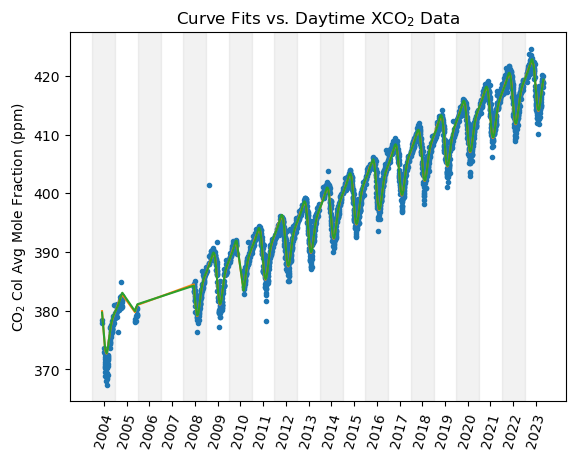

In [17]:
t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_day['pa'].index])/86400./365.
plt.plot(t,lef_day['pa']['xco2'],'.')
plt.plot(t,thoning(t,*pt['pa']))
plt.plot(t,skewsine(t*365,*ps['pa']))
plt.title('Curve Fits vs. Daytime XCO$_2$ Data')
plt.ylabel('CO$_2$ Col Avg Mole Fraction (ppm)')
for i in range(4,23,2):
    plt.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
plt.xticks(np.arange(4.5,24,1),np.arange(2004,2024),rotation=75);


Text(0.5, 0, 'Hour of Day (LST)')

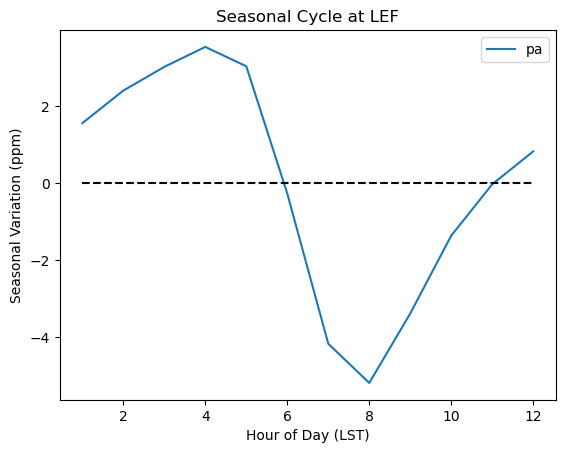

In [18]:
fig,ax=plt.subplots(1,1)
for ky in sites:
    lef_day[ky]['detrend'] = lef_day[ky].thoning-lef_day[ky].trend
    seas = lef_day[ky].groupby(lef_day[ky]['xco2'].index.month)['detrend'].mean()
    seas.plot()
ax.legend(sites)
ax.set_title(f'Seasonal Cycle at LEF')
ax.set_ylabel('Seasonal Variation (ppm)')
ax.legend(sites)
#ax.set_ylim([-3,38])
ax.plot([1,12],[0,0],'--k')
ax.set_xlabel('Hour of Day (LST)')

## Questions

1. How does this seasonal cycle compare to the in situ data?
2. What might be causing the differences?

## Examination of Residuals

Text(0, 0.5, 'Residual (ppm)')

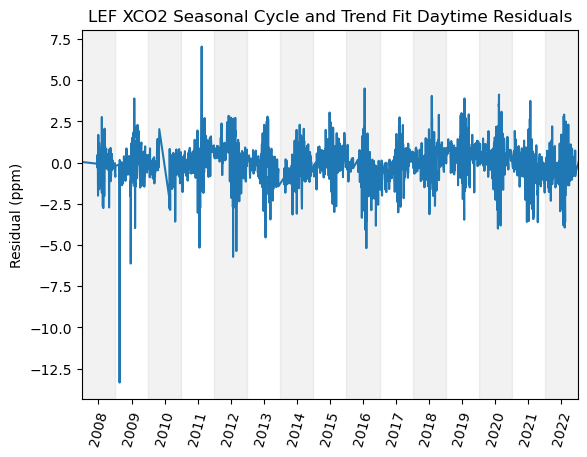

In [19]:
plt.plot(t,thoning(t,*pt['pa'])-lef_day['pa']['xco2'])
for i in range(0,23,2):
    plt.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
plt.xticks(np.arange(0.5,23,1),np.arange(2000,2023),rotation=75);
plt.xlim([8,23])
plt.title('LEF XCO2 Seasonal Cycle and Trend Fit Daytime Residuals')
plt.ylabel('Residual (ppm)')

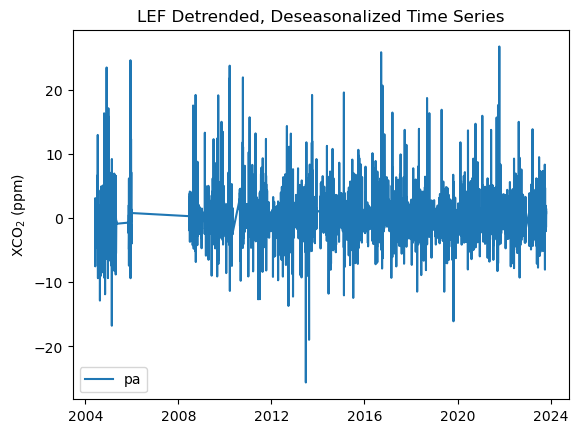

In [20]:
for st in lef_all.keys():
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in lef_all[st].index])/86400./365
    plt.plot(lef_all[st].xco2-thoning(t,*pt[st]))
plt.title('LEF Detrended, Deseasonalized Time Series')
plt.ylabel('XCO$_2$ (ppm)')
plt.legend(sites)

## Questions

1. How do you interpret the parameters in the curve fits?
2. How would you interpret the residuals in the daytime data after fitting the curves?
3. What do the large remaining variations in the fits versus the full time series represent?

# Diurnal Cycle Analysis

With detrended and deseasonalized data, we can start to examine other frequencies of variability.  The first place to look is changes over the course of a day from season to season.

## First create a detrended, deseasonalized time series:

In [21]:
for st in sites:
    tmp = lef_all[st]
    t = np.array([(ti-dt.datetime(2000,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    lef_all[st]['xco2_de'] = lef_all[st].xco2-thoning(t,*pt[st])

## Now use groupby to plot diurnal cycle for 4 different months

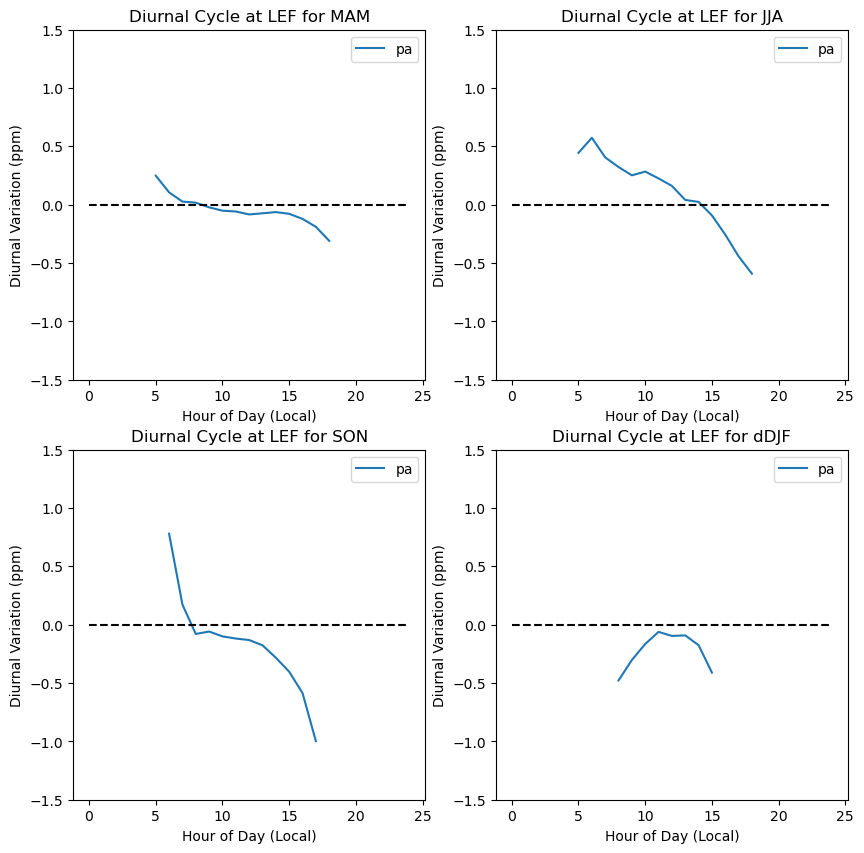

In [22]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
for isn,sn in enumerate(['MAM','JJA','SON','dDJF']):
  ax = axs[isn//2,isn%2]
  for ky in sites:
    inds = np.where((lef_all[ky].index.month > 3*isn+2)*(lef_all[ky].index.month <= 3*isn+5))
    if sn == 'DJF':
      inds = np.where((lef_all[ky].index.month == 12) + (lef_all[ky].index.month < 3))
    ssn_ts = lef_all[ky].iloc[inds]
    ts = ssn_ts.groupby(ssn_ts['xco2_de'].index.hour)['xco2_de'].mean()
    ax.plot(ts)
  ax.legend(sites)
  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax.set_ylabel('Diurnal Variation (ppm)')
  ax.set_ylim([-1.5,1.5])
  ax.plot([0,24],[0,0],'--k')
  ax.set_xlabel('Hour of Day (Local)')

## Questions

1. Why is there no data at night?
2. What drives the differences in daytime minimum mole fractions between the different seasons?
3. What are we assuming about the statistics of the detrended, deseasonalized time series when we make these plots?

# Synoptic Variations

/var/folders/rs/19n1gwk93bx64vmlp3fgdy_h0000gn/T/ipykernel_54455/74009332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ts['synoptic'] = syn_ts['xco2_de']


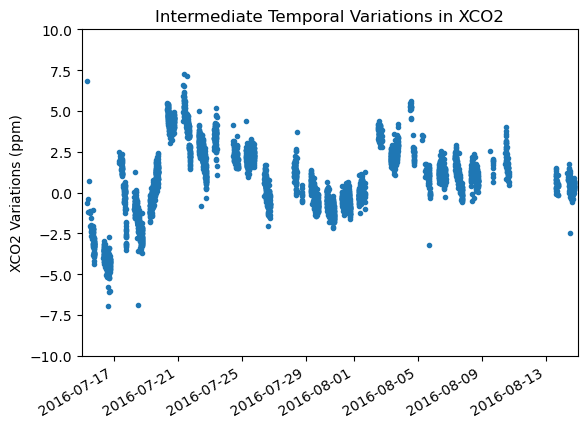

In [23]:
for ky in sites:
  inds = np.where((lef_all[ky].index.month == 6) + (lef_all[ky].index.year == 2016))
  syn_ts = lef_all[ky].iloc[inds]
  ts = syn_ts.groupby(syn_ts['xco2_de'].index.hour)['xco2_de'].mean()
  syn_ts['synoptic'] = syn_ts['xco2_de']
  syn_ts['synoptic'].plot(marker='.',linestyle='')
plt.xlim([dt.datetime(2016,7,15),dt.datetime(2016,8,15)])
plt.ylim([-10,10])
plt.title('Intermediate Temporal Variations in XCO2');
plt.ylabel('XCO2 Variations (ppm)');

## Questions

1. How do these variations compare to the in situ data?
2. What would cause the differences between the two different datasets?

# Extra Credit: Combine the $\textit{in situ}$ analysis with the TCCON analysis in a single notebook